# Project 2

In [1]:
# Import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import skew, kurtosis

## Question 1

### Black-Scholes Functions

In [2]:
# Parameters
np.random.seed(0)
S0 = 10                     # Initial stock price
K = 10                      # Strike price of option g
T = 63 / 252                # Maturity of option g (63 trading days)
r = 0.05                    # Risk-free rate
sigma = 0.25                # Volatility
n_paths = 5000              # Number of simulated paths
n_steps = 63                # Number of steps (daily hedging)
dt = T / n_steps            # Time step
transaction_cost = 0.005    # Transaction cost per stock and option
num_options = 10000         # Number of options sold

# Sed seed for reproducibility
np.random.seed(0)

# Simulate stock price paths
def simulate_stock_paths(S0, mu, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Black-Scholes Delta
def black_scholes_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Black-Scholes Gamma
def black_scholes_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

# Black-Scholes Call Price
def black_scholes_call_price(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

### Delta Hedging

In [3]:
# Delta Hedging
def delta_hedging(stock_paths, K, T, r, sigma, dt, transaction_cost, num_options):
    n_paths = stock_paths.shape[1]
    n_steps = stock_paths.shape[0] - 1
    bank_positions = np.zeros((n_steps + 1, n_paths))
    stock_positions = np.zeros((n_steps + 1, n_paths))

    # Initial delta and cash position
    delta_g_0 = np.round(num_options * black_scholes_delta(stock_paths[0], K, T, r, sigma))
    g_0 = num_options * black_scholes_call_price(stock_paths[0], K, r, sigma, T)
    initial_transaction_cost = transaction_cost * delta_g_0  # Initial transaction cost
    bank_positions[0] = g_0 - delta_g_0 * stock_paths[0] - initial_transaction_cost
    stock_positions[0] = delta_g_0

    for t in range(1, n_steps):
        time_to_maturity = T - t * dt

        # New stock position alpha_{t_1}
        stock_positions[t] = np.round(num_options * black_scholes_delta(stock_paths[t], K, time_to_maturity, r, sigma))

        # Stock position difference alpha_{t_0} - alpha_{t_1}
        stock_diff = stock_positions[t - 1] - stock_positions[t]

        # Transaction costs
        transaction_cost_t = transaction_cost * np.abs(stock_diff)

        # Rebalanced bank account B_{t_1}
        bank_positions[t] = (
            # B_{t_0}*e^{t_1-t_0}
            bank_positions[t - 1] * np.exp(r * dt)
            # (alpha_{t_0} - alpha_{t_1})*S_{t_1}
            + stock_diff * stock_paths[t]
            - transaction_cost_t
        )

    # Final P&L
    option_payoff = num_options * np.maximum(stock_paths[-1] - K, 0)
    final_stock_value = stock_positions[-2] * stock_paths[-1]
    final_transaction_cost = stock_positions[-2] * transaction_cost

    pnl = (
        bank_positions[-2]*np.exp(r*dt)     # Cash in bank
        + final_stock_value                 # Value of stocks
        - option_payoff                     # Option g
        - final_transaction_cost            # Transaction cost for stocks
    )
    
    return pnl

### Delta-Gamma Hedging

In [4]:
# Delta-Gamma Hedging
def delta_gamma_hedging(stock_paths, K_g, T_g, K_h, T_h, r, sigma, dt, transaction_cost, num_options):
    n_paths = stock_paths.shape[1]
    n_steps = stock_paths.shape[0] - 1
    bank_positions = np.zeros((n_steps + 1, n_paths))
    stock_positions = np.zeros((n_steps + 1, n_paths))
    option_h_positions = np.zeros((n_steps + 1, n_paths))

    # Initial deltas and gamma for option g and h
    delta_g_0 = num_options * black_scholes_delta(stock_paths[0], K_g, T_g, r, sigma)
    gamma_g_0 = num_options * black_scholes_gamma(stock_paths[0], K_g, T_g, r, sigma)
    gamma_h_0 = black_scholes_gamma(stock_paths[0], K_h, T_h, r, sigma)
    delta_h_0 = black_scholes_delta(stock_paths[0], K_h, T_h, r, sigma)

    # Initial gamma-neutral and delta-neutral positions
    eta_0 = np.round((gamma_g_0 / gamma_h_0))
    alpha_0 = np.round((delta_g_0 - eta_0 * delta_h_0))

    # Initial option g and h values
    g_0 = num_options * black_scholes_call_price(stock_paths[0], K_g, r, sigma, T_g)
    h_0 = black_scholes_call_price(stock_paths[0], K_h, r, sigma, T_h)

    # Initial transaction costs
    transaction_cost_0 = transaction_cost * (np.abs(alpha_0) + np.abs(eta_0))

    # Initialize stock/option g, option h, and bank positions
    bank_positions[0] = g_0 - alpha_0 * stock_paths[0] - eta_0 * h_0 - transaction_cost_0
    stock_positions[0] = alpha_0
    option_h_positions[0] = eta_0

    for t in range(1, n_steps):
        time_to_maturity_g = T_g - t * dt
        time_to_maturity_h = T_h - t * dt

        # Time t deltas and gamma for option g and h
        delta_g = num_options * black_scholes_delta(stock_paths[t], K_g, time_to_maturity_g, r, sigma)
        gamma_g = num_options * black_scholes_gamma(stock_paths[t], K_g, time_to_maturity_g, r, sigma)
        delta_h = black_scholes_delta(stock_paths[t], K_h, time_to_maturity_h, r, sigma)
        gamma_h = black_scholes_gamma(stock_paths[t], K_h, time_to_maturity_h, r, sigma)

        # Time t gamma-neutral and delta-neutral positions
        option_h_positions[t] = np.round(gamma_g / gamma_h)
        stock_positions[t] = np.round(delta_g - option_h_positions[t] * delta_h)

        # Time t stock/option g position differences and option h position differences
        stock_diff = stock_positions[t] - stock_positions[t - 1]
        option_h_diff = option_h_positions[t] - option_h_positions[t - 1]

        # Time t transaction costs
        transaction_cost_t = (
            transaction_cost * np.abs(stock_diff) +
            transaction_cost * np.abs(option_h_diff)
        )

        # Update bank account
        bank_positions[t] = (
            bank_positions[t - 1] * np.exp(r * dt)
            - stock_diff * stock_paths[t]
            - option_h_diff * black_scholes_call_price(stock_paths[t], K_h, r, sigma, time_to_maturity_h)
            - transaction_cost_t
        )

    # Final P&L
    option_g_payoff = num_options * np.maximum(stock_paths[-1] - K_g, 0)
    final_stock_value = stock_positions[-2] * stock_paths[-1]
    final_option_h_value = option_h_positions[-2] * black_scholes_call_price(stock_paths[-1], K_h, r, sigma, time_to_maturity_h)
    final_transaction_cost_stock = transaction_cost * np.abs(stock_positions[-2])
    final_transaction_cost_option_h = transaction_cost * np.abs(option_h_positions[-2])

    pnl = (
        bank_positions[-2] * np.exp(r * dt)     # Cash in bank
        + final_stock_value                     # Value of stocks
        - option_g_payoff                       # Option g payoff
        + final_option_h_value                  # Value of option h
        - final_transaction_cost_stock          # Transaction cost for stocks
        - final_transaction_cost_option_h       # Transaction cost for option h
    )

    return pnl

### Separate Plots

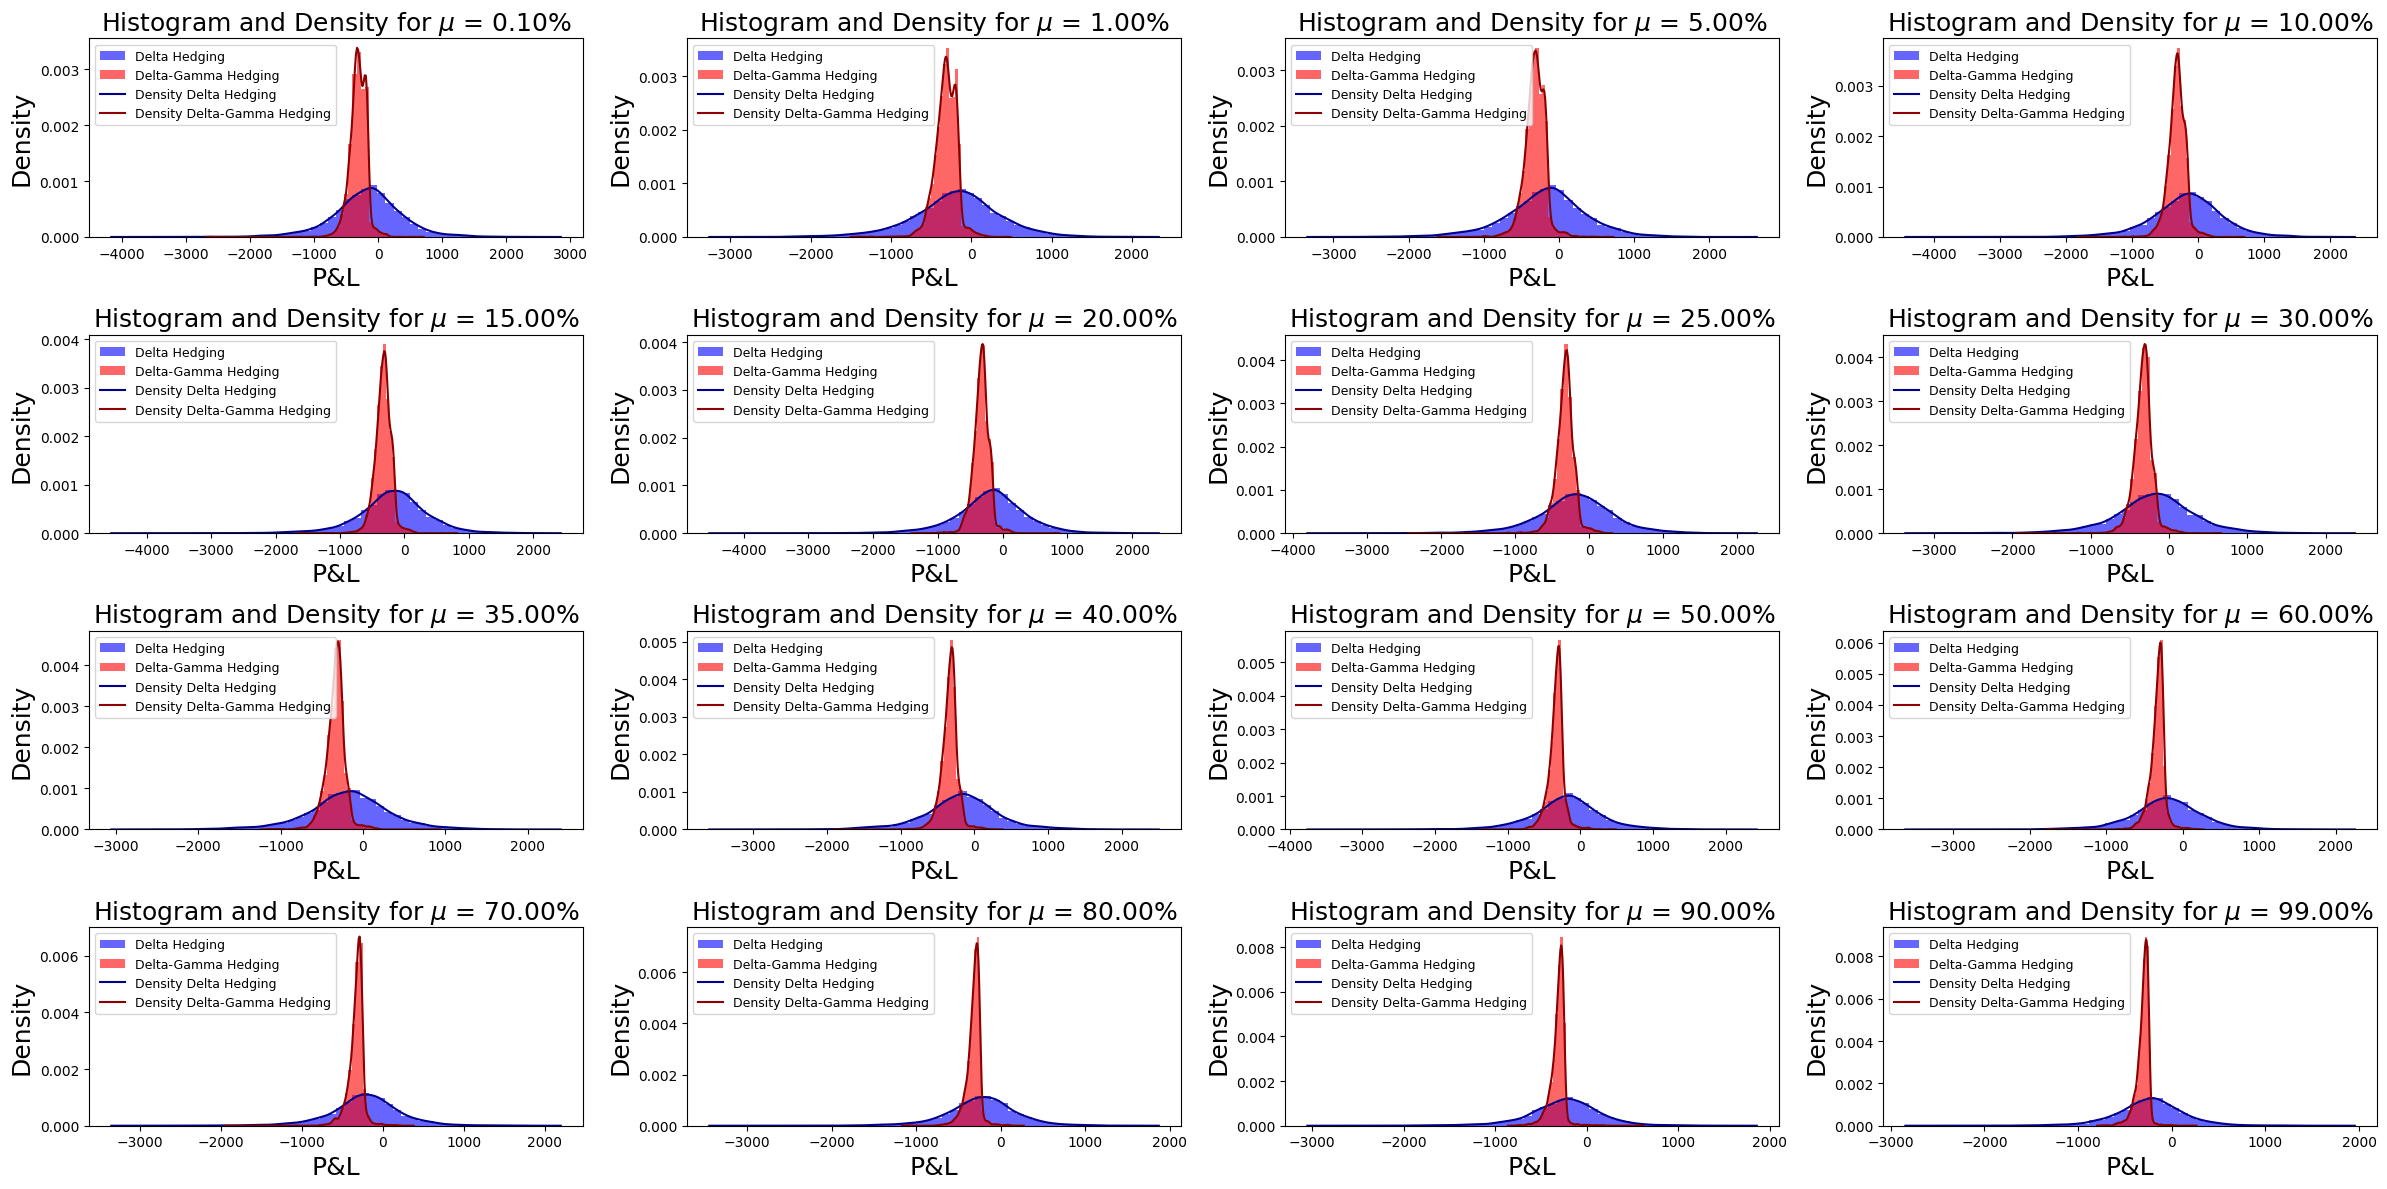

In [5]:
# Set seed for reproducibility
np.random.seed(0)

# Varifying mu values
mu_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

# Dynamic figure creation for histograms and density plots across different mu values
n_mu = len(mu_values)

# Prepare for histogram and density plots
fig_hist_density, axes_hist_density = plt.subplots((n_mu + 1) // 4, 4, figsize=(16*1.5, n_mu/2*1.5))  # Dynamic rows
axes_hist_density = axes_hist_density.flatten()

# Loop through each mu value
for i, mu in enumerate(mu_values):
    # Simulate stock paths
    stock_paths_mu = simulate_stock_paths(S0, mu, sigma, T, n_steps, n_paths)

    # Calculate P&L for Delta Hedging and Delta-Gamma Hedging
    pnl_delta = delta_hedging(stock_paths_mu, K, T, r, sigma, dt, transaction_cost, num_options)
    pnl_delta_gamma = delta_gamma_hedging(stock_paths_mu, K, T, K, T + 0.05, r, sigma, dt, transaction_cost, num_options)

    # Histogram with density plot overlay
    ax_hist_density = axes_hist_density[i]
    ax_hist_density.hist(pnl_delta, bins=50, alpha=0.6, label="Delta Hedging", color="blue", density=True)
    ax_hist_density.hist(pnl_delta_gamma, bins=50, alpha=0.6, label="Delta-Gamma Hedging", color="red", density=True)

    sns.kdeplot(pnl_delta, ax=ax_hist_density, color="darkblue", label="Density Delta Hedging")
    sns.kdeplot(pnl_delta_gamma, ax=ax_hist_density, color="darkred", label="Density Delta-Gamma Hedging")


    ax_hist_density.set_title(f'Histogram and Density for $\mu$ = {mu:.2%}', fontsize=18)
    ax_hist_density.set_xlabel('P&L', fontsize=18)
    ax_hist_density.set_ylabel('Density', fontsize=18)
    ax_hist_density.legend(loc='upper left', fontsize=9)

# Adjust layout
fig_hist_density.tight_layout()
plt.show()

### Combined Plots

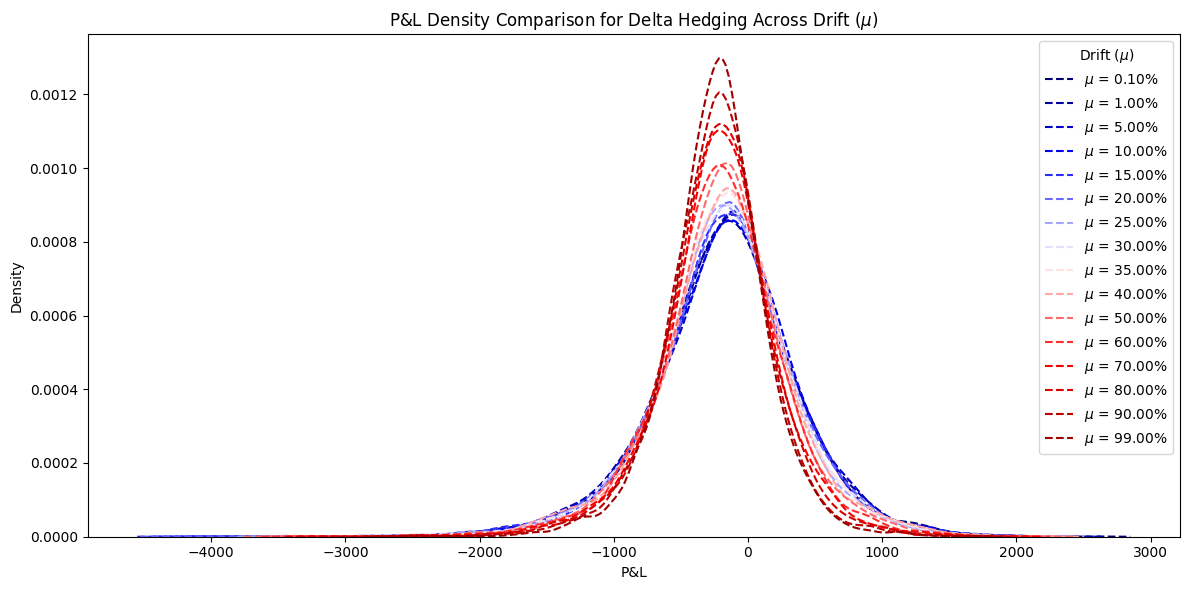

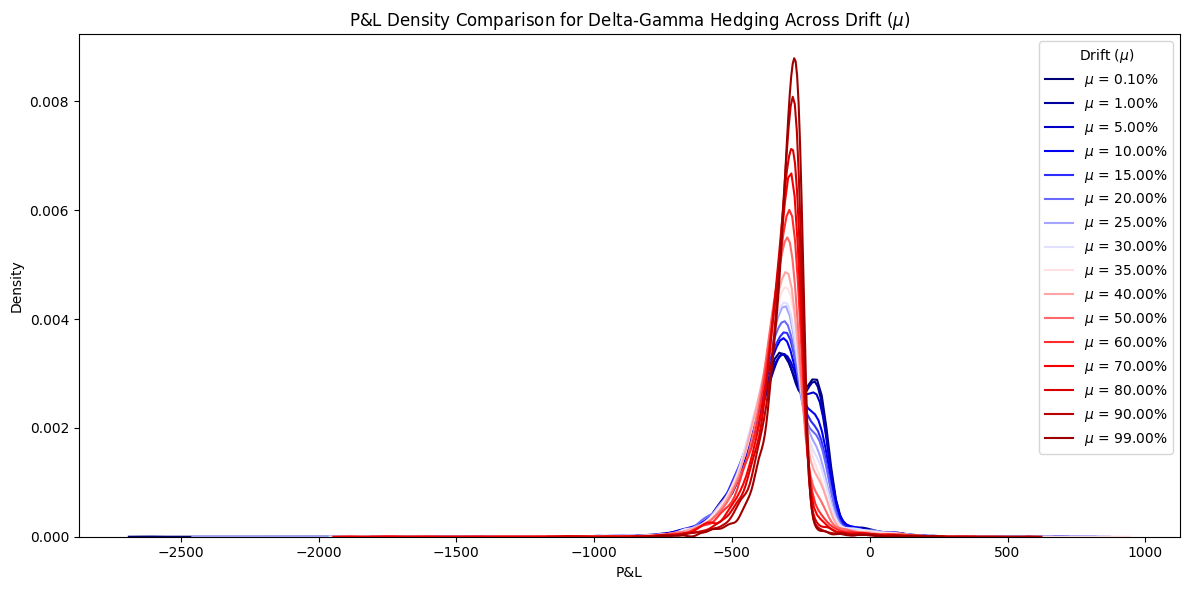

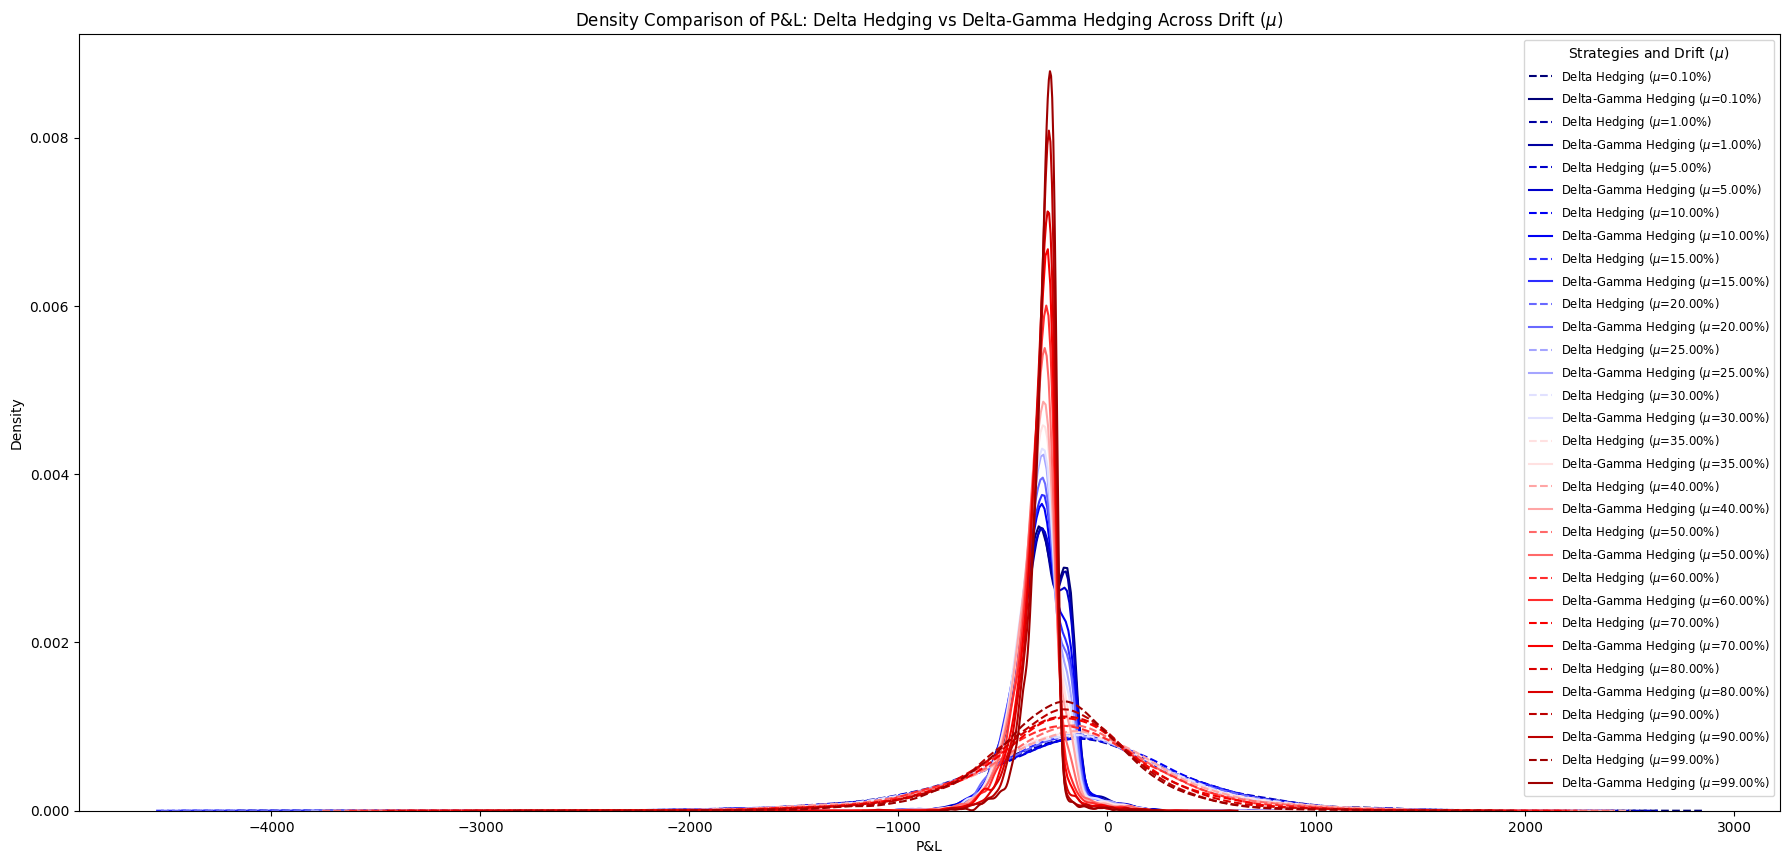

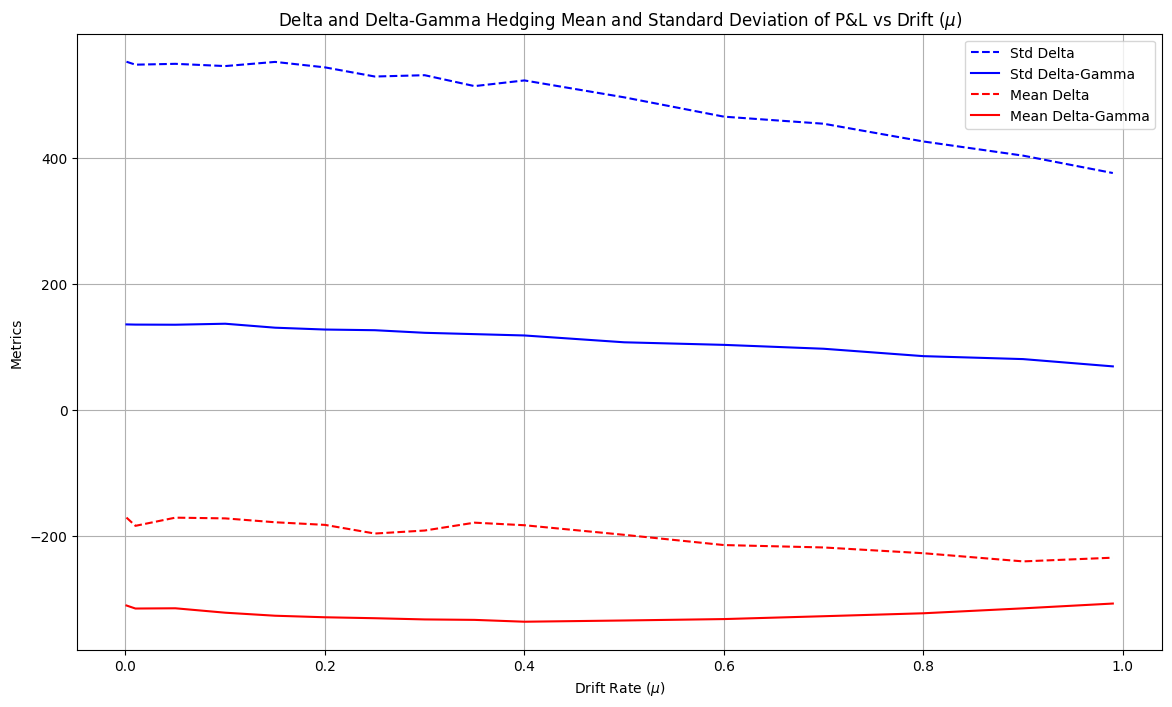

,Mu,Mean Delta,Std Delta,Max Delta,Skewness Delta,Kurtosis Delta,Mean Delta-Gamma,Std Delta-Gamma,Max Delta-Gamma,Skewness Delta-Gamma,Kurtosis Delta-Gamma
0,0.001,-170.791712,552.808735,2547.564431,-0.306514,2.217782,-310.376977,135.826586,641.319266,-1.558974,21.941536
1,0.010,-183.920300,548.119961,2034.447176,-0.292411,1.195190,-315.187627,135.521212,419.471873,-0.692484,4.676924
2,0.050,-170.936272,549.465102,2334.342871,-0.310017,1.380260,-314.800192,135.312841,649.982862,-0.288823,4.363580
3,0.100,-172.093750,545.905194,2074.537307,-0.355846,1.840213,-321.805284,136.898773,627.708677,-0.899093,8.533239
4,0.150,-178.242798,552.518433,2128.572964,-0.431408,2.510944,-326.618032,130.611794,748.854819,-0.522990,7.380812
5,0.200,-182.396232,543.861573,2113.571230,-0.390005,2.062646,-329.066715,127.680426,802.409077,-0.454842,5.495437
6,0.250,-196.152271,529.324678,1972.058517,-0.456078,2.372420,-330.568331,126.609331,238.344980,-1.250666,17.070761
7,0.300,-191.377102,531.406527,2081.177123,-0.417915,2.058693,-332.490102,122.499980,596.781018,-0.553003,8.809183
8,0.350,-178.887769,514.096716,2119.541593,-0.213332,1.563185,-333.201061,120.379862,878.608703,-0.264814,6.501976
9,0.400,-182.966943,523.120669,2219.563719,-0.308822,2.115497,-336.132339,118.262097,319.625266,-1.210443,13.324467


In [6]:
# Set seed for reproducibility
np.random.seed(0)

# Varifying mu values
mu_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

# Prepare lists for results
skewness_delta = []
kurtosis_delta = []
mean_delta = []
std_delta = []
max_delta = []

skewness_delta_gamma = []
kurtosis_delta_gamma = []
mean_delta_gamma = []
std_delta_gamma = []
max_delta_gamma = []

# Single comparative density plots
fig_combined_delta = plt.figure(figsize=(12, 6))  # All Delta Hedging densities in one plot
fig_combined_gamma = plt.figure(figsize=(12, 6))  # All Delta-Gamma Hedging densities in one plot
fig_combined_both = plt.figure(figsize=(18, 9))  # Combined Delta and Delta-Gamma densities

colors = sns.color_palette("seismic", len(mu_values))

# Loop through each mu value
for i, mu in enumerate(mu_values):
    # Simulate stock paths
    stock_paths_mu = simulate_stock_paths(S0, mu, sigma, T, n_steps, n_paths)

    # Calculate P&L for Delta Hedging and Delta-Gamma Hedging
    pnl_delta = delta_hedging(stock_paths_mu, K, T, r, sigma, dt, transaction_cost, num_options)
    pnl_delta_gamma = delta_gamma_hedging(stock_paths_mu, K, T, K, T + 0.05, r, sigma, dt, transaction_cost, num_options)

    # Compute skewness, kurtosis, mean, std, and max for Delta
    skewness_delta.append(skew(pnl_delta))
    kurtosis_delta.append(kurtosis(pnl_delta))
    mean_delta.append(np.mean(pnl_delta))
    std_delta.append(np.std(pnl_delta))
    max_delta.append(np.max(pnl_delta))

    # Compute skewness, kurtosis, mean, std, and max for Delta-Gamma
    skewness_delta_gamma.append(skew(pnl_delta_gamma))
    kurtosis_delta_gamma.append(kurtosis(pnl_delta_gamma))
    mean_delta_gamma.append(np.mean(pnl_delta_gamma))
    std_delta_gamma.append(np.std(pnl_delta_gamma))
    max_delta_gamma.append(np.max(pnl_delta_gamma))

    # Add to combined Delta Hedging densities plot
    plt.figure(fig_combined_delta.number)
    sns.kdeplot(pnl_delta, color=colors[i], label=f"$\mu$ = {mu:.2%}", linestyle="--")

    # Add to combined Delta-Gamma Hedging densities plot
    plt.figure(fig_combined_gamma.number)
    sns.kdeplot(pnl_delta_gamma, color=colors[i], label=f"$\mu$ = {mu:.2%}", linestyle="-")

    # Add to combined Delta and Delta-Gamma densities plot
    plt.figure(fig_combined_both.number)
    sns.kdeplot(pnl_delta, color=colors[i], label=f"Delta Hedging ($\mu$={mu:.2%})", linestyle="--")
    sns.kdeplot(pnl_delta_gamma, color=colors[i], label=f"Delta-Gamma Hedging ($\mu$={mu:.2%})", linestyle="-")

# Finalize combined plots
plt.figure(fig_combined_delta.number)
plt.title("P&L Density Comparison for Delta Hedging Across Drift ($\mu$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Drift ($\mu$)", loc="upper right")
plt.tight_layout()

plt.figure(fig_combined_gamma.number)
plt.title("P&L Density Comparison for Delta-Gamma Hedging Across Drift ($\mu$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Drift ($\mu$)", loc="upper right")
plt.tight_layout()

plt.figure(fig_combined_both.number)
plt.title("Density Comparison of P&L: Delta Hedging vs Delta-Gamma Hedging Across Drift ($\mu$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Strategies and Drift ($\mu$)", loc="upper right", fontsize="small")
plt.tight_layout()

# Show all plots
plt.show()

# Create the results table
results = pd.DataFrame({
    'Mu': mu_values,
    'Mean Delta': mean_delta,
    'Std Delta': std_delta,
    'Max Delta': max_delta,
    'Skewness Delta': skewness_delta,
    'Kurtosis Delta': kurtosis_delta,
    'Mean Delta-Gamma': mean_delta_gamma,
    'Std Delta-Gamma': std_delta_gamma,
    'Max Delta-Gamma': max_delta_gamma,
    'Skewness Delta-Gamma': skewness_delta_gamma,
    'Kurtosis Delta-Gamma': kurtosis_delta_gamma
})

# Plot statistics
plt.figure(figsize=(14, 8))
plt.plot(mu_values, std_delta, '--', label='Std Delta', color="blue")
plt.plot(mu_values, std_delta_gamma, '-', label='Std Delta-Gamma', color="blue")
plt.plot(mu_values, mean_delta, '--', label='Mean Delta', color="red")
plt.plot(mu_values, mean_delta_gamma, '-', label='Mean Delta-Gamma', color="red")


plt.title('Delta and Delta-Gamma Hedging Mean and Standard Deviation of P&L vs Drift ($\mu$)')
plt.xlabel('Drift Rate ($\mu$)')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

results

## Question 2

C:\Users\sxiny\AppData\Local\Temp\ipykernel_116940\560748381.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\sxiny\AppData\Local\Temp\ipykernel_116940\560748381.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\sxiny\AppData\Local\Temp\ipykernel_116940\560748381.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return norm.pdf(d1) / (S * sigma * np.sqrt(T))


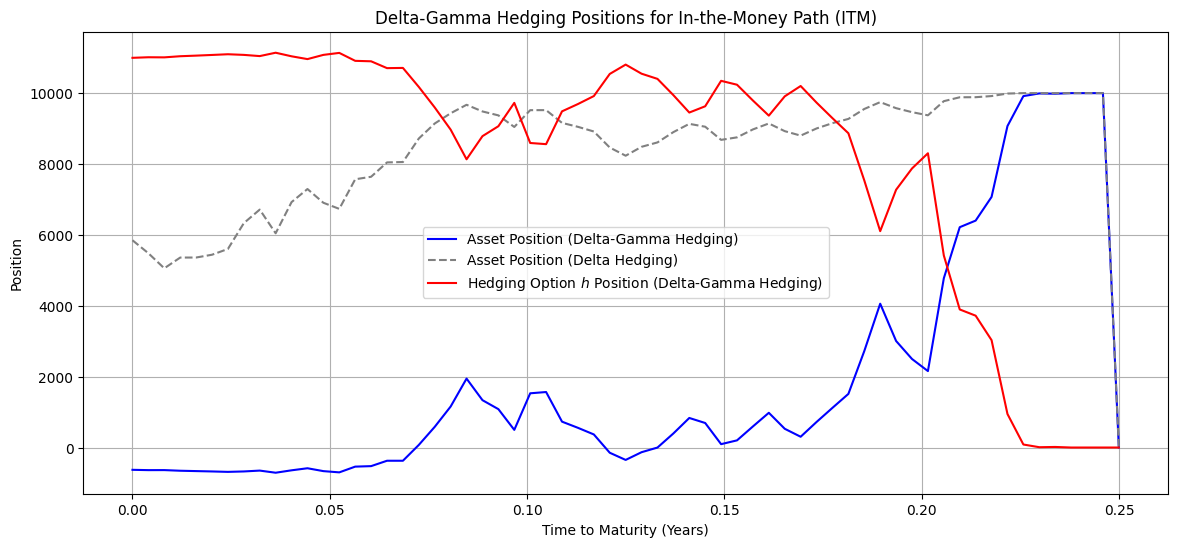

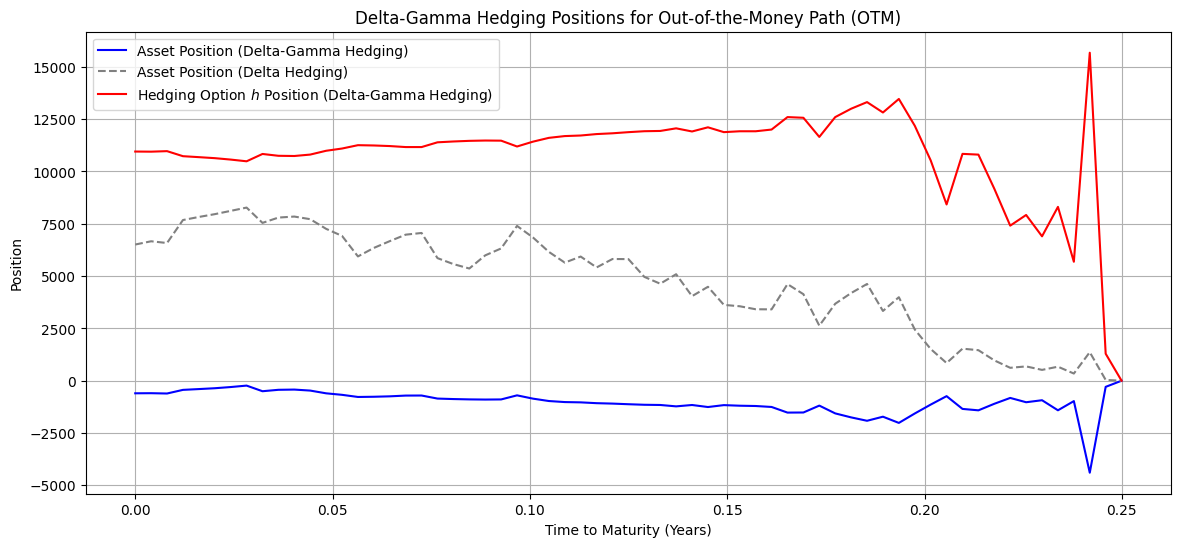

In [7]:
# Parameters
np.random.seed(0)
S0 = 10                     # Initial stock price
K = 10                      # Strike price of option g
T = 63 / 252                # Maturity of option g (63 trading days)
r = 0.05                    # Risk-free rate
sigma = 0.25                # Volatility
n_paths = 5000              # Number of simulated paths
n_steps = 63                # Number of steps (daily hedging)
dt = T / n_steps            # Time step
transaction_cost = 0.005    # Transaction cost per stock and option
num_options = 10000         # Number of options sold

# Simulate stock price paths
def simulate_stock_paths(S0, mu, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Simulate stock paths
np.random.seed(0)  # Ensure reproducibility for both paths
stock_paths = simulate_stock_paths(S0, mu=0.1, sigma=sigma, T=T, n_steps=n_steps, n_paths=n_paths)

# Select two paths: one in-the-money (ITM), one out-of-the-money (OTM)
itm_path_index = np.argmax(stock_paths[-1] > K)  # Path ending ITM
otm_path_index = np.argmax(stock_paths[-1] <= K)  # Path ending OTM

# Extract selected paths
stock_path_itm = stock_paths[:, itm_path_index]
stock_path_otm = stock_paths[:, otm_path_index]

# Run Delta-Gamma hedging to get positions in the asset and hedging option
positions_itm_stock = []
positions_itm_delta = []
positions_itm_option_h = []
positions_otm_stock = []
positions_otm_delta = []
positions_otm_option_h = []

for t in range(1, n_steps + 1):
    # ITM path
    time_to_maturity_itm_g = T - t * dt
    time_to_maturity_itm = T - t * dt
    time_to_maturity_itm_h = T + 0.05 - t * dt

    delta_itm_g = num_options * black_scholes_delta(stock_path_itm[t], K, time_to_maturity_itm_g, r, sigma)
    gamma_itm_g = num_options * black_scholes_gamma(stock_path_itm[t], K, time_to_maturity_itm_g, r, sigma)
    delta_itm = np.round(num_options * black_scholes_delta(stock_path_itm[t], K, time_to_maturity_itm, r, sigma))
    delta_itm_h = black_scholes_delta(stock_path_itm[t], K, time_to_maturity_itm_h, r, sigma)
    gamma_itm_h = black_scholes_gamma(stock_path_itm[t], K, time_to_maturity_itm_h, r, sigma)

    eta_itm = np.round(gamma_itm_g / gamma_itm_h)
    alpha_itm = np.round(delta_itm_g - eta_itm * delta_itm_h)
    positions_itm_stock.append(alpha_itm)
    positions_itm_delta.append(delta_itm)
    positions_itm_option_h.append(eta_itm)

    # OTM path
    time_to_maturity_otm_g = T - t * dt
    time_to_maturity_otm = T - t * dt
    time_to_maturity_otm_h = T + 0.05 - t * dt

    delta_otm_g = num_options * black_scholes_delta(stock_path_otm[t], K, time_to_maturity_otm_g, r, sigma)
    gamma_otm_g = num_options * black_scholes_gamma(stock_path_otm[t], K, time_to_maturity_otm_g, r, sigma)
    delta_otm = np.round(num_options * black_scholes_delta(stock_path_otm[t], K, time_to_maturity_otm, r, sigma))
    delta_otm_h = black_scholes_delta(stock_path_otm[t], K, time_to_maturity_otm_h, r, sigma)
    gamma_otm_h = black_scholes_gamma(stock_path_otm[t], K, time_to_maturity_otm_h, r, sigma)

    eta_otm = np.round(gamma_otm_g / gamma_otm_h)
    alpha_otm = np.round(delta_otm_g - eta_otm * delta_otm_h)
    positions_otm_stock.append(alpha_otm)
    positions_otm_delta.append(delta_otm)
    positions_otm_option_h.append(eta_otm)
    
# Set the first and last time point positions to zero for all paths
positions_itm_stock[-1] = positions_itm_delta[-1] = positions_itm_option_h[-1] = 0
positions_otm_stock[-1] = positions_otm_delta[-1] = positions_otm_option_h[-1] = 0

# Time vector for plotting
time = np.linspace(0, T + 1/252, n_steps + 1)

# Re-plot positions for ITM path
plt.figure(figsize=(14, 6))
plt.plot(time[:-1], positions_itm_stock, label="Asset Position (Delta-Gamma Hedging)", color="blue")
plt.plot(time[:-1], positions_itm_delta, label="Asset Position (Delta Hedging)", color="gray", linestyle="--")
plt.plot(time[:-1], positions_itm_option_h, label="Hedging Option $h$ Position (Delta-Gamma Hedging)", color="red")
plt.title("Delta-Gamma Hedging Positions for In-the-Money Path (ITM)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()

# Re-plot positions for OTM path
plt.figure(figsize=(14, 6))
plt.plot(time[:-1], positions_otm_stock, label="Asset Position (Delta-Gamma Hedging)", color="blue")
plt.plot(time[:-1], positions_otm_delta, label="Asset Position (Delta Hedging)", color="gray", linestyle="--")
plt.plot(time[:-1], positions_otm_option_h, label="Hedging Option $h$ Position (Delta-Gamma Hedging)", color="red")
plt.title("Delta-Gamma Hedging Positions for Out-of-the-Money Path (OTM)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()


## Question 3

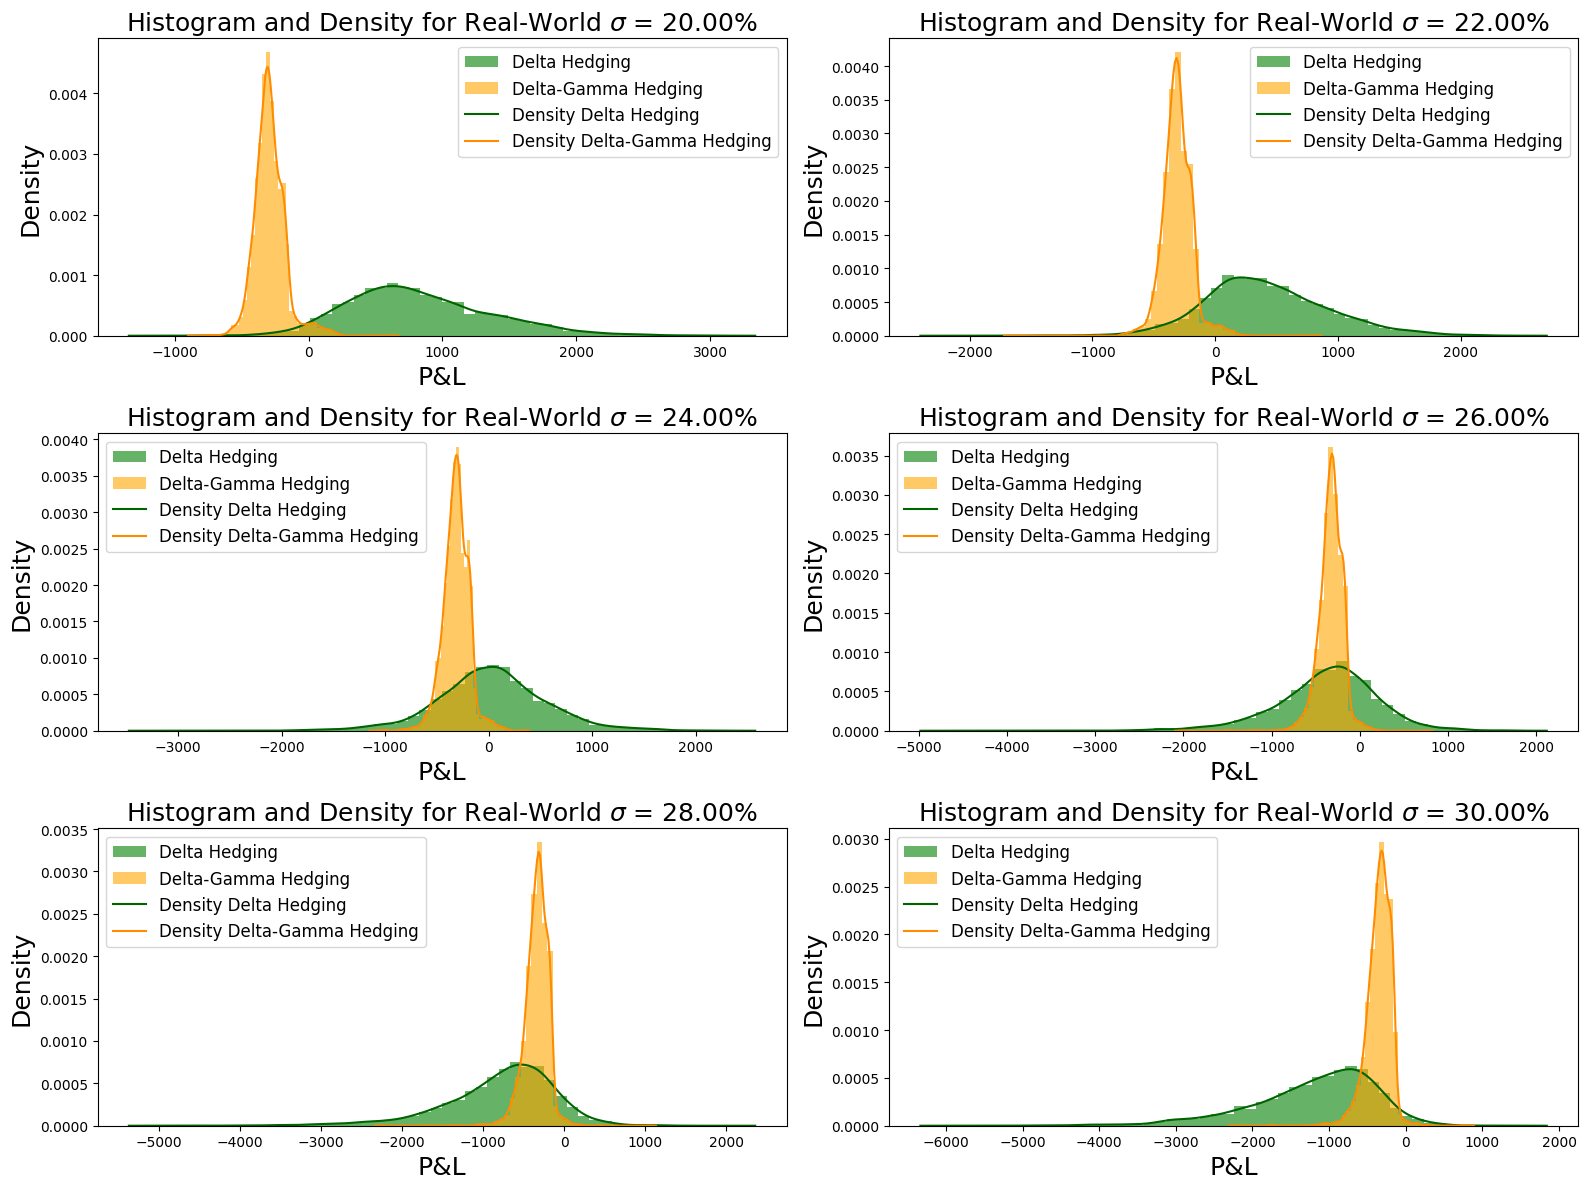

In [8]:
# Set seed for reproducibility
np.random.seed(0)

# Fixed mu values
mu = 0.1

# Varifying sigmas for simulated stock paths
real_world_sigmas = np.arange(0.20, 0.32, 0.02)

# Dynamic figure creation for histograms and density plots across different mu values
n_sigma = len(real_world_sigmas)

# Prepare for histogram and density plots
fig_hist_density, axes_hist_density = plt.subplots(n_sigma//2, 2, figsize=(16, n_sigma * 2))  # Dynamic rows
axes_hist_density = axes_hist_density.flatten()

# Loop through each mu value
for i, real_world_sigma in enumerate(real_world_sigmas):
    # Simulate stock paths
    stock_paths_mu = simulate_stock_paths(S0, mu, real_world_sigma, T, n_steps, n_paths)

    # Calculate P&L for Delta Hedging and Delta-Gamma Hedging
    pnl_delta = delta_hedging(stock_paths_mu, K, T, r, sigma, dt, transaction_cost, num_options)
    pnl_delta_gamma = delta_gamma_hedging(stock_paths_mu, K, T, K, T + 0.05, r, sigma, dt, transaction_cost, num_options)

    # Histogram with density plot overlay
    ax_hist_density = axes_hist_density[i]
    ax_hist_density.hist(pnl_delta, bins=50, alpha=0.6, label="Delta Hedging", color="green", density=True)
    ax_hist_density.hist(pnl_delta_gamma, bins=50, alpha=0.6, label="Delta-Gamma Hedging", color="orange", density=True)

    sns.kdeplot(pnl_delta, ax=ax_hist_density, color="darkgreen", label="Density Delta Hedging")
    sns.kdeplot(pnl_delta_gamma, ax=ax_hist_density, color="darkorange", label="Density Delta-Gamma Hedging")

    ax_hist_density.set_title(f'Histogram and Density for Real-World $\sigma$ = {real_world_sigma:.2%}', fontsize=18)
    ax_hist_density.set_xlabel('P&L', fontsize=18)
    ax_hist_density.set_ylabel('Density', fontsize=18)
    ax_hist_density.legend(fontsize=12)

# Adjust layout
fig_hist_density.tight_layout()
plt.show()

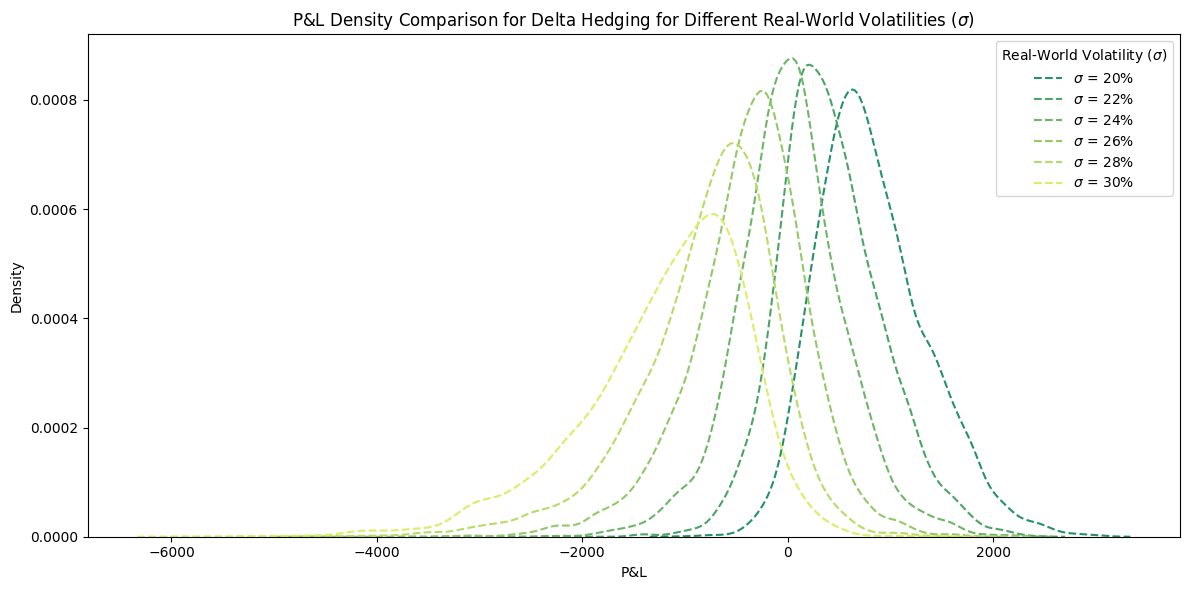

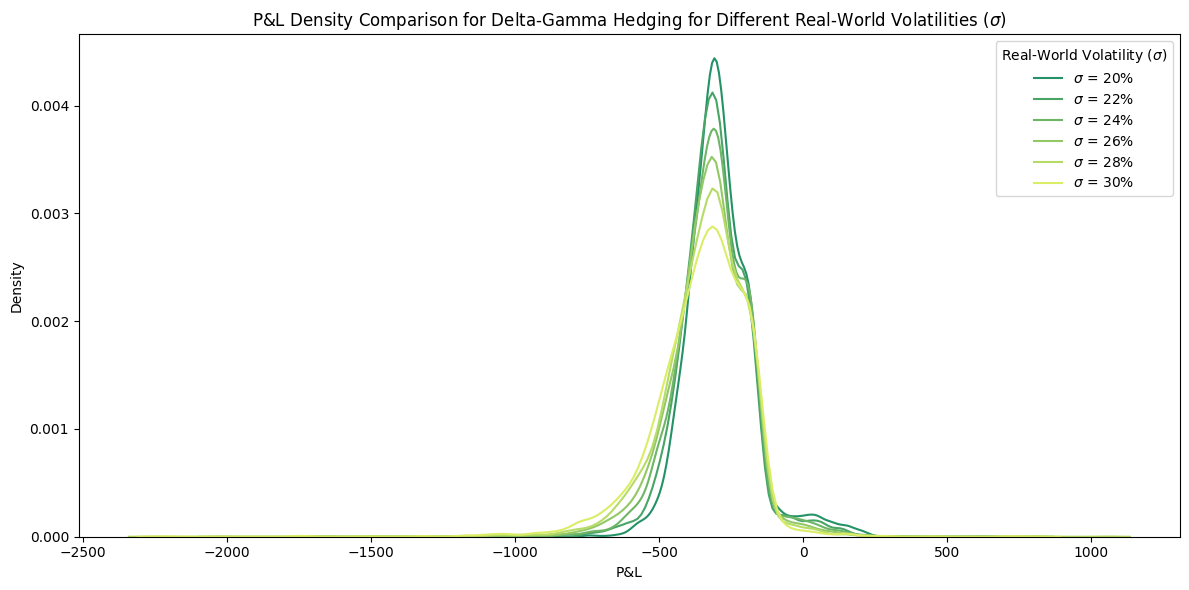

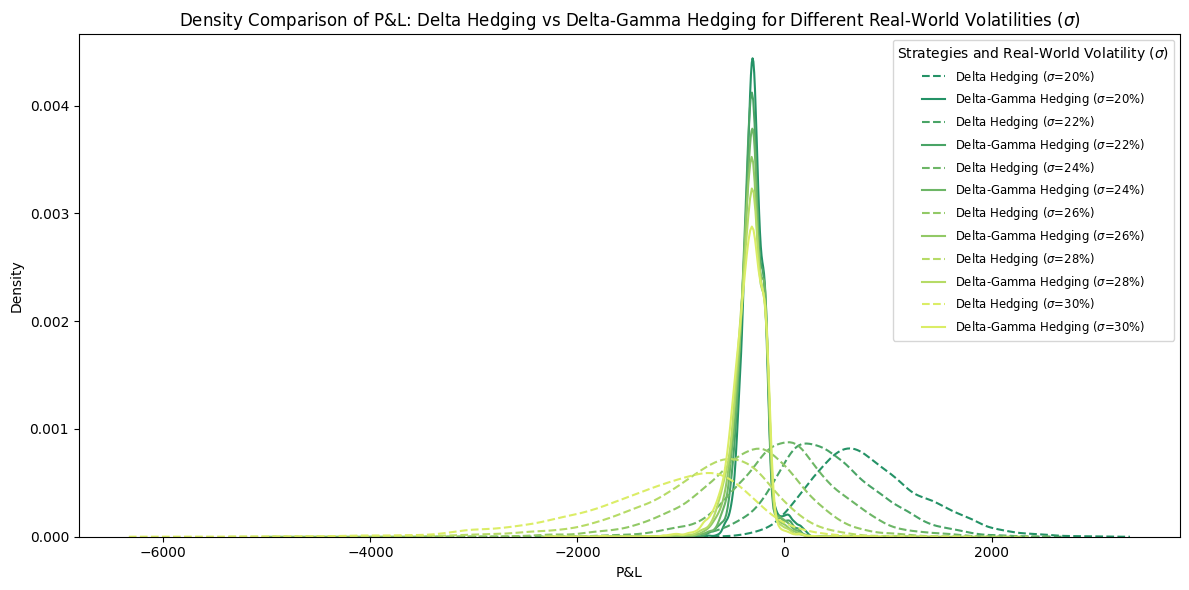

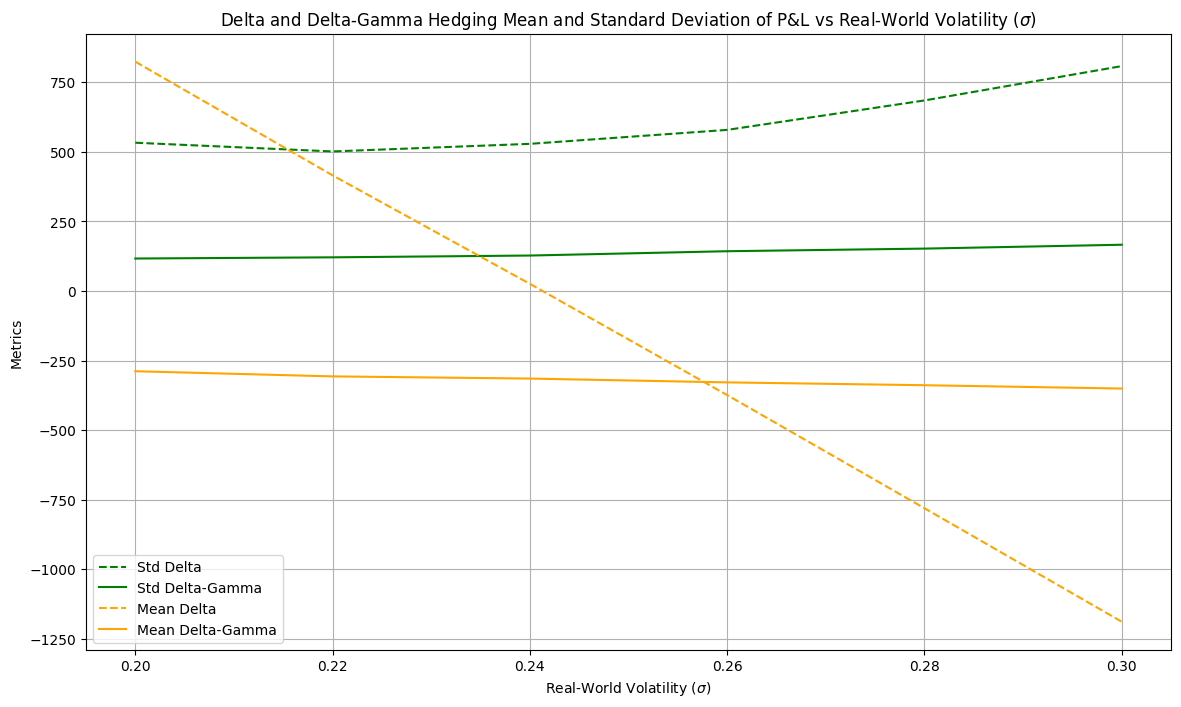

,Real-World Volatility,Mean Delta,Std Delta,Max Delta,Skewness Delta,Kurtosis Delta,Mean Delta-Gamma,Std Delta-Gamma,Max Delta-Gamma,Skewness Delta-Gamma,Kurtosis Delta-Gamma
0,0.20,823.912360,532.845106,3045.893581,0.568943,0.384151,-288.238638,116.765948,609.476972,0.913657,3.254691
1,0.22,415.494707,501.518688,2427.117378,0.326340,0.575258,-306.759345,121.057720,802.601943,0.125629,6.526932
2,0.24,25.779032,528.834459,2286.518692,-0.044715,1.440178,-314.586127,127.497606,331.488722,-0.212788,2.669647
3,0.26,-373.937620,578.970382,1801.513013,-0.612060,2.036717,-328.276910,142.987085,750.393197,-1.230540,11.107246
4,0.28,-780.568421,684.784096,1984.319141,-1.044479,2.503256,-338.486155,152.402353,1050.327541,-1.299351,11.972962
5,0.30,-1188.292718,808.122317,1398.698271,-0.983715,1.559543,-350.435974,166.280099,799.889980,-1.348400,9.599869


In [9]:
# Set seed for reproducibility
np.random.seed(0)

# Fixed mu values
mu = 0.1

# Varifying sigmas for simulated stock paths
real_world_sigmas = np.arange(0.20, 0.32, 0.02)

# Prepare lists for results
skewness_delta = []
kurtosis_delta = []
mean_delta = []
std_delta = []
max_delta = []

skewness_delta_gamma = []
kurtosis_delta_gamma = []
mean_delta_gamma = []
std_delta_gamma = []
max_delta_gamma = []

# Single comparative density plots
fig_combined_delta = plt.figure(figsize=(12, 6))  # All Delta Hedging densities in one plot
fig_combined_gamma = plt.figure(figsize=(12, 6))  # All Delta-Gamma Hedging densities in one plot
fig_combined_both = plt.figure(figsize=(12, 6))  # Combined Delta and Delta-Gamma densities

colors = sns.color_palette("summer", len(real_world_sigmas))

# Loop through each mu value
for i, real_world_sigma in enumerate(real_world_sigmas):
    # Simulate stock paths
    stock_paths_mu = simulate_stock_paths(S0, mu, real_world_sigma, T, n_steps, n_paths)

    # Calculate P&L for Delta Hedging and Delta-Gamma Hedging
    pnl_delta = delta_hedging(stock_paths_mu, K, T, r, sigma, dt, transaction_cost, num_options)
    pnl_delta_gamma = delta_gamma_hedging(stock_paths_mu, K, T, K, T + 0.05, r, sigma, dt, transaction_cost, num_options)

    # Compute skewness, kurtosis, mean, std, and max for Delta
    skewness_delta.append(skew(pnl_delta))
    kurtosis_delta.append(kurtosis(pnl_delta))
    mean_delta.append(np.mean(pnl_delta))
    std_delta.append(np.std(pnl_delta))
    max_delta.append(np.max(pnl_delta))

    # Compute skewness, kurtosis, mean, std, and max for Delta-Gamma
    skewness_delta_gamma.append(skew(pnl_delta_gamma))
    kurtosis_delta_gamma.append(kurtosis(pnl_delta_gamma))
    mean_delta_gamma.append(np.mean(pnl_delta_gamma))
    std_delta_gamma.append(np.std(pnl_delta_gamma))
    max_delta_gamma.append(np.max(pnl_delta_gamma))

    # Add to combined Delta Hedging densities plot
    plt.figure(fig_combined_delta.number)
    sns.kdeplot(pnl_delta, color=colors[i], label=f"$\sigma$ = {real_world_sigma:.0%}", linestyle="--")

    # Add to combined Delta-Gamma Hedging densities plot
    plt.figure(fig_combined_gamma.number)
    sns.kdeplot(pnl_delta_gamma, color=colors[i], label=f"$\sigma$ = {real_world_sigma:.0%}", linestyle="-")

    # Add to combined Delta and Delta-Gamma densities plot
    plt.figure(fig_combined_both.number)
    sns.kdeplot(pnl_delta, color=colors[i], label=f"Delta Hedging ($\sigma$={real_world_sigma:.0%})", linestyle="--")
    sns.kdeplot(pnl_delta_gamma, color=colors[i], label=f"Delta-Gamma Hedging ($\sigma$={real_world_sigma:.0%})", linestyle="-")

# Finalize combined plots
plt.figure(fig_combined_delta.number)
plt.title("P&L Density Comparison for Delta Hedging for Different Real-World Volatilities ($\sigma$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Real-World Volatility ($\sigma$)", loc="upper right")
plt.tight_layout()

plt.figure(fig_combined_gamma.number)
plt.title("P&L Density Comparison for Delta-Gamma Hedging for Different Real-World Volatilities ($\sigma$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Real-World Volatility ($\sigma$)", loc="upper right")
plt.tight_layout()

plt.figure(fig_combined_both.number)
plt.title("Density Comparison of P&L: Delta Hedging vs Delta-Gamma Hedging for Different Real-World Volatilities ($\sigma$)")
plt.xlabel("P&L")
plt.ylabel("Density")
plt.legend(title="Strategies and Real-World Volatility ($\sigma$)", loc="upper right", fontsize="small")
plt.tight_layout()

# Show all plots
plt.show()

# Create the results table
results = pd.DataFrame({
    'Real-World Volatility': real_world_sigmas,
    'Mean Delta': mean_delta,
    'Std Delta': std_delta,
    'Max Delta': max_delta,
    'Skewness Delta': skewness_delta,
    'Kurtosis Delta': kurtosis_delta,
    'Mean Delta-Gamma': mean_delta_gamma,
    'Std Delta-Gamma': std_delta_gamma,
    'Max Delta-Gamma': max_delta_gamma,
    'Skewness Delta-Gamma': skewness_delta_gamma,
    'Kurtosis Delta-Gamma': kurtosis_delta_gamma
})

# Plot statistics
plt.figure(figsize=(14, 8))
plt.plot(real_world_sigmas, std_delta, '--', label='Std Delta', color="green")
plt.plot(real_world_sigmas, std_delta_gamma, '-', label='Std Delta-Gamma', color="green")
plt.plot(real_world_sigmas, mean_delta, '--', label='Mean Delta', color="orange")
plt.plot(real_world_sigmas, mean_delta_gamma, '-', label='Mean Delta-Gamma', color="orange")

plt.title('Delta and Delta-Gamma Hedging Mean and Standard Deviation of P&L vs Real-World Volatility ($\sigma$)')
plt.xlabel('Real-World Volatility ($\sigma$)')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

results